# Library imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error

np.warnings.filterwarnings('ignore')

C:\Users\Pau\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
t0 = time.time()

# Functions and Classes

In [3]:
def get_point_coordinate_from_pixel_coordinate(pixel_coordinate, point_precision):
    """
    Adjusts the coordinates of a pixel to the coordinates of the point it corresponds to.
    
    Args:
        - pixel_coordinate: the coordinate of a pixel, only a singel axis.
        - point_precision: the precision of the groundtruth.
    Returns:
        - the coordinate of the point the pixel corresponds to.
    """
    floor_divided_pixel = pixel_coordinate // (point_precision/2)
    if floor_divided_pixel % 2:
        return floor_divided_pixel * (point_precision/2)
    else:
        return (floor_divided_pixel + 1) * (point_precision/2)

In [4]:
class FeatureExtractor:
    """
    Extracts the features of each point based on the pixels inside it.
    
    Attributes
    ----------
    input_data : Pandas DataFrame
        LiDAR input information with the coordinates of the points corresponding to each pixel.
    
    Methods
    -------
    mean_height(name='mean_height')
    num_pixels(name='num_pixels')
    num_ground(name='num_ground')
    num_low_vegetation(name='num_low_vegetation')
    num_medium_vegetation(name='num_medium_vegetation')
    num_high_vegetation(name='num_high_vegetation')
    num_building(name='num_building')
    num_low_point(name='num_low_point')
    max_height_diff(name='max_height_diff')
    
    """
    
    def __init__(self, input_data, block_height_grouping=6):
        
        if not set(['x_p', 'y_p', 'x', 'y', 'c', 'a']).issubset(set(input_data.columns)):
            print("Error: Input data does not have the required columns")
            
        self.xp = 'x_p'      # pixel's point x coordinate column name
        self.yp = 'y_p'      # pixel's point y coordinate column name
        self.x = 'x'         # pixel x coordinate column name
        self.y = 'y'         # pixel y coordinate column name
        self.c = 'c'         # pixel class column name
        self.a = 'a'         # pixel angle columns name

        self.data = self._get_heights(input_data, block_height_grouping)  # LiDAR data with point-assigned pixels and its height
        self.grouped = self.data.groupby([self.xp, self.yp]) # pixels grouped by point
          
        
    def _get_heights(self, input_data, grouping):
        input_data['height_merging_x'] = ( input_data[self.x] // grouping ) * grouping
        input_data['height_merging_y'] = ( input_data[self.y] // grouping ) * grouping

        input_copy = input_data.copy()

        input_copy = input_copy.groupby(['height_merging_x', 'height_merging_y'])['z'].min().reset_index()
        input_copy = input_copy.rename({'z':'surface_z'}, axis=1)

        input_data = pd.merge(input_data, input_copy, how='left', on=['height_merging_x', 'height_merging_y'])
        input_data['height'] = input_data['z'] - input_data['surface_z']

        input_data = input_data.drop(['z', 'surface_z', 'height_merging_x', 'height_merging_y'], axis=1)
        
        return input_data
    
    def not_cassified_pts(self, name='not_classified_pts'):
        # NEW
        '''
        Number of points that are not vegetation nor ground.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)        
        '''
        aux_arr = self.data.query('c not in [3, 4, 5, 6, 7]').copy()
        
        aux_arr = aux_arr.groupby([self.xp, self.yp])[self.c].count()
        
        return aux_arr.rename(name)
        
           
    def angle_mean(self, name='angle_mean'):
        # NEW
        '''
        Mean angle of scanning.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        '''
        values = self.grouped[self.a].mean()
        return values.rename(name, inplace=True)
    
    def angle_quantile(self, quant=0.5, name='angle_Q'):
        # NEW
        """
        Quantile value of the height array of that point.
        
        Parameters
        ----------
        quant: Percentage of the quantile. Range: [0,1]
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped[self.a].quantile(quant)
        return values.rename(name+str(round(quant,2)), inplace=True)
    
    def angle_sd(self, name='angle_sd'):
        # NEW
        '''
        The standard deviation of the angle Array of that point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        '''
        values = self.grouped[self.a].std()
        return values.rename(name, inplace=True)
    
    def angle_max_diff(self, name='angle_max_diff'):
        # NEW
        """
        The difference between the highest angle and the lowest angleu.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped[self.a].max()
        return values.rename(name, inplace=True)
    
    def height_quantile(self, quant, name='height_Q'):
        """
        Quantile value of the height array of that point.
        
        Parameters
        ----------
        quant: Percentage of the quantile. Range: [0,1]
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].quantile(quant)
        return values.rename(name+str(round(quant,2)), inplace=True)
        
    def threshold_percentage(self, threshold, name='above_threshold_pct_'):
        """
        Percentage of points above a certain threshold.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        my_block = self.data.query('c in [3,4,5]').copy()
        df_canopy = my_block.query('height > @threshold').copy()

        df_canopy['counted_canopy'] = np.zeros(df_canopy.shape[0])
        df_canopy = df_canopy.groupby([self.xp, self.yp])[['counted_canopy']].count().reset_index()

        my_block['counted_no_canopy'] = np.zeros(my_block.shape[0])
        my_block = my_block.groupby([self.xp, self.yp])[['counted_no_canopy']].count().reset_index()

        my_block = pd.merge(my_block, df_canopy, how='left', on = [self.xp, self.yp])

        my_block['counted_canopy'].fillna(0, inplace=True)
        my_block[name+str(threshold)] = 100*my_block['counted_canopy'] / my_block['counted_no_canopy']
        
        my_block.drop(['counted_canopy', "counted_no_canopy"], axis=1, inplace = True)
        
        return my_block
    
    def sd_height(self, name='sd_height'):
        '''
        The standard deviation of the height Array of that point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        '''
        values = self.grouped['height'].std()
        return values.rename(name, inplace=True)
        
    def max_height_diff(self, name='max_height_diff'):
        """
        The difference between the highest LiDAR point and the lowest LiDAR point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].max()
        return values.rename(name, inplace=True)
    
    def height_second_max(self, name='height_second_max'):
        """
        The second highest LiDAR point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].nlargest(2).reset_index().drop('level_2', axis=1)
        
        return values.rename({'height':name}, axis=1)
    
    def mean_height(self, name='mean_height'):
        """
        Mean height with respect to the geoid.
         
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].mean()
        return values.rename(name, inplace=True)
    
    def num_pixels(self, name='num_pixels'):
        """
        Number of pixels of each point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped.count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_ground(self, name='num_ground'):
        """
        Number of pixels classified as "ground".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==2] # 2 corresponds to "low vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_low_vegetation(self, name='num_low_vegetation'):
        """
        Number of pixels classified as "low vegetation".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==3] # 3 corresponds to "low vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_medium_vegetation(self, name='num_medium_vegetation'):
        """
        Number of pixels classified as "medium vegetation".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==4] # 4 corresponds to "low vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_high_vegetation(self, name='num_high_vegetation'):
        """
        Number of pixels classified as "high vegetation".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==5] # 5 corresponds to "high vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_building(self, name='num_building'):
        """
        Number of pixels classified as "building".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==6] # 6 corresponds to "building"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_low_point(self, name='num_low_point'):
        """
        Number of pixels classified as "low point".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==7] # 7 corresponds to "low point"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)


# Script

In [5]:
t0_load = time.time()
# Constants
toy_gt_path = '../toy dataset/groundtruth_toydataset.csv'
toy_input_path = '../toy dataset/input_toydataset-xyzrnaic.txt'
nonzero_gt_path = '../nonzerogt_dataset/groundtruth_nonzerogt.csv'
nonzero_input_path = '../nonzerogt_dataset/input_nonzerogt.txt'
full_gt_path = '../fullblock_dataset/groundtruth_fullblock.csv'
full_input_path = '../fullblock_dataset/input_fullblock.txt'

groundtruth_datapath = full_gt_path                                  # Where the groundturh data is stored
groundtruth_columns = ['x', 'y', 'CC']                              # Groundturth data columns
groundtruth_precision = 20                                          # Groundturth precision in meters
point_p_d2 = groundtruth_precision/2

input_datapath = full_input_path                                     # Where the input data is storedº
input_columns = ['x','y','z', 'c', 'a', 'n','r']                                  # Input data columns
outliers = 135

### Creation of the dataset

In [6]:
# LiDAR and groundtruth reading
my_block = pd.read_csv(input_datapath, sep=' ', header = None, names = input_columns)
groundtruth = pd.read_csv(groundtruth_datapath, sep=' ', header = None, names = groundtruth_columns)

t1_load = time.time()

t0_adjust = time.time()

In [7]:
# Adjusting the groundtruth. CC cannot exceed 100
groundtruth['CC'] = [x if x<100 else 100 for x in groundtruth['CC']]

In [8]:
# Removing outliers
my_block = my_block.query('c != @outliers')

aux_xp = my_block['x'] // point_p_d2
aux_yp = my_block['y'] // point_p_d2

my_block['x_p'] = aux_xp * point_p_d2 + point_p_d2 * ( 1 - ( aux_xp % 2 ) )
my_block['y_p'] = aux_yp * point_p_d2 + point_p_d2 * ( 1 - ( aux_yp % 2 ) )

In [9]:
# Creating the final dataset
data = groundtruth.copy()
    # Necessary in order to merge later
data.rename(columns={"x": "x_p", "y": "y_p"}, inplace=True)

t1_adjust = time.time()

In [10]:
# Creating the feature extractor object
t0_FE = time.time()
FE = FeatureExtractor(my_block, 6)

In [11]:
# Adding the features to the dataset

t_aux0 = time.time()
data = data.merge(FE.mean_height(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_pixels(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_ground(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_low_vegetation(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_medium_vegetation(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_high_vegetation(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_building(), how='left', on=['x_p', 'y_p'])

data = data.merge(FE.max_height_diff(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.height_second_max(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.sd_height(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.not_cassified_pts(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.angle_mean(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.angle_sd(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.angle_max_diff(), how='left', on=['x_p', 'y_p'])
t_aux1 = time.time()
for q in np.arange(0, 1, 0.1):
    data = data.merge(FE.angle_quantile(q), how='left', on=['x_p', 'y_p'])
for q in np.arange(0,1,0.1):
    data = data.merge(FE.height_quantile(q), how='left', on=['x_p', 'y_p'])
for t in np.arange(2, 6, 0.5):
    data = data.merge(FE.threshold_percentage(t), how='left', on=['x_p', 'y_p'])
t_aux2 = time.time()

data.fillna(0, inplace=True)
t1_FE = time.time()

In [12]:
print("before:",t_aux1-t_aux0,"\nAfter:", t_aux2-t_aux1)

before: 8.885279178619385 
After: 68.36376357078552


In [13]:
# Showing some rows to check if it looks as expected
data[0:5]

,x_p,y_p,CC,mean_height,num_pixels,num_ground,num_low_vegetation,num_medium_vegetation,num_high_vegetation,num_building,...,height_Q0.8,height_Q0.9,above_threshold_pct_2.0,above_threshold_pct_2.5,above_threshold_pct_3.0,above_threshold_pct_3.5,above_threshold_pct_4.0,above_threshold_pct_4.5,above_threshold_pct_5.0,above_threshold_pct_5.5
0,430010.0,4635990.0,0.0,3.790470,1873,377.0,372.0,0.0,27.0,0.0,...,2.290,3.580,31.578947,23.308271,16.791980,12.280702,9.273183,8.020050,6.766917,6.766917
1,430010.0,4635990.0,0.0,3.790470,1873,377.0,372.0,0.0,27.0,0.0,...,2.290,3.580,31.578947,23.308271,16.791980,12.280702,9.273183,8.020050,6.766917,6.766917
2,430030.0,4635990.0,0.0,1.097868,2003,385.0,381.0,10.0,0.0,0.0,...,1.676,2.938,37.851662,32.480818,30.179028,26.598465,21.227621,12.787724,7.416880,2.301790
3,430030.0,4635990.0,0.0,1.097868,2003,385.0,381.0,10.0,0.0,0.0,...,1.676,2.938,37.851662,32.480818,30.179028,26.598465,21.227621,12.787724,7.416880,2.301790
4,430050.0,4635990.0,0.0,0.783853,2014,319.0,475.0,63.0,9.0,0.0,...,0.864,1.237,25.228519,25.045704,24.131627,20.109689,17.733090,12.614260,8.409506,2.010969


### EDA

In [14]:
t0_EDA = time.time()
data.shape

(20000, 45)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   x_p                      20000 non-null  float64
 1   y_p                      20000 non-null  float64
 2   CC                       20000 non-null  float64
 3   mean_height              20000 non-null  float64
 4   num_pixels               20000 non-null  int64  
 5   num_ground               20000 non-null  float64
 6   num_low_vegetation       20000 non-null  float64
 7   num_medium_vegetation    20000 non-null  float64
 8   num_high_vegetation      20000 non-null  float64
 9   num_building             20000 non-null  float64
 10  max_height_diff          20000 non-null  float64
 11  height_second_max        20000 non-null  float64
 12  sd_height                20000 non-null  float64
 13  not_classified_pts       20000 non-null  int64  
 14  angle_mean            

In [16]:
data.describe()

,x_p,y_p,CC,mean_height,num_pixels,num_ground,num_low_vegetation,num_medium_vegetation,num_high_vegetation,num_building,...,height_Q0.8,height_Q0.9,above_threshold_pct_2.0,above_threshold_pct_2.5,above_threshold_pct_3.0,above_threshold_pct_3.5,above_threshold_pct_4.0,above_threshold_pct_4.5,above_threshold_pct_5.0,above_threshold_pct_5.5
count,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,431000.000000,4.635000e+06,39.904917,5.381349,799.570200,38.763500,110.467700,13.787700,354.973300,1.448400,...,9.354055,11.162483,82.314614,78.761730,75.620708,72.966889,70.629129,68.412890,66.172048,63.787150
std,577.335835,5.773358e+02,28.659150,2.425447,686.098941,47.852041,131.820215,21.174429,350.434017,15.602132,...,3.920526,4.418129,17.012595,18.440628,19.615169,20.547994,21.225175,21.675741,22.029205,22.371445
min,430010.000000,4.634010e+06,0.000000,0.180202,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,430505.000000,4.634505e+06,20.717500,3.856360,373.000000,13.000000,34.000000,3.000000,125.000000,0.000000,...,7.440000,9.110000,79.869040,75.555556,71.774194,68.497720,65.416615,62.521956,59.332583,55.685857
50%,431000.000000,4.635000e+06,40.140000,5.445434,582.000000,24.000000,64.000000,8.000000,272.000000,0.000000,...,9.680000,11.232000,87.976894,84.875999,82.162615,79.798990,77.567098,75.247525,72.680412,70.080354
75%,431495.000000,4.635495e+06,54.292500,6.893225,947.250000,46.000000,135.000000,17.000000,432.000000,0.000000,...,11.952500,13.586500,92.073171,89.779510,87.725340,85.871100,84.229892,82.634731,80.943541,79.213552
max,431990.000000,4.635990e+06,100.000000,33.961247,6993.000000,700.000000,2001.000000,445.000000,2892.000000,513.000000,...,42.700000,58.806000,100.000000,100.000000,100.000000,100.000000,98.901099,98.901099,98.901099,98.901099


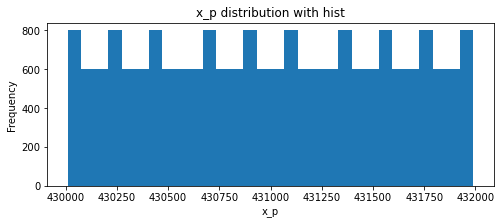

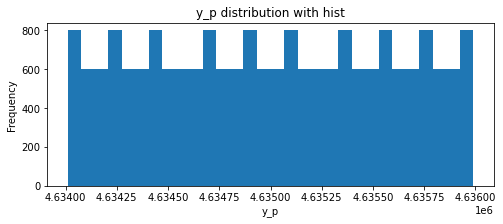

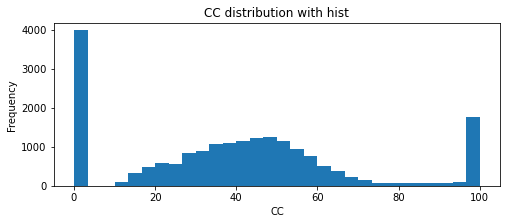

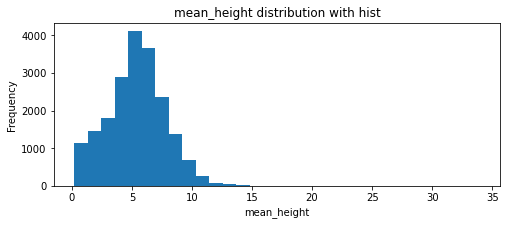

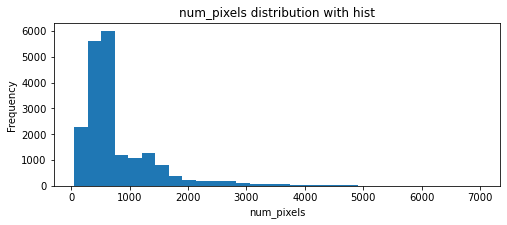

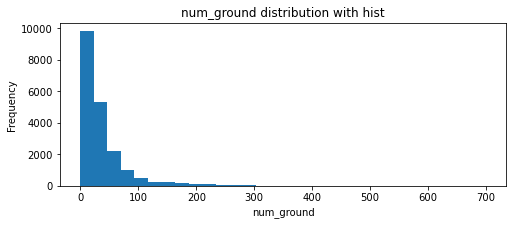

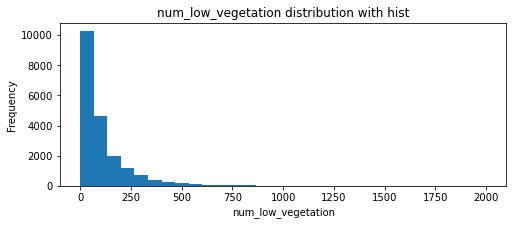

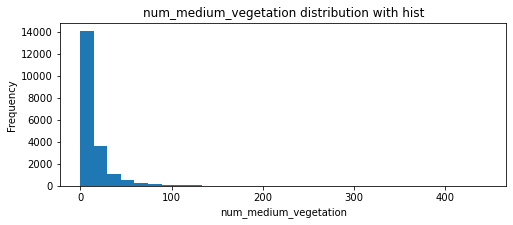

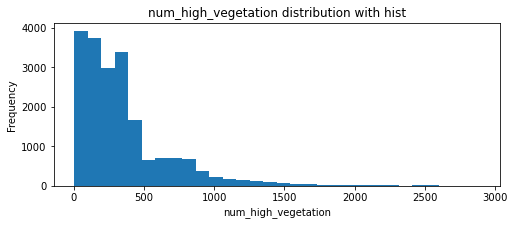

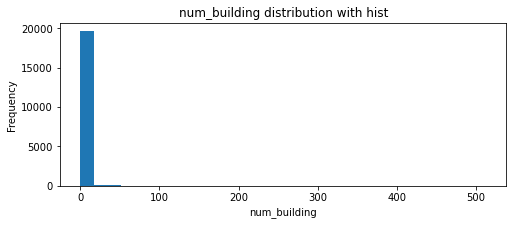

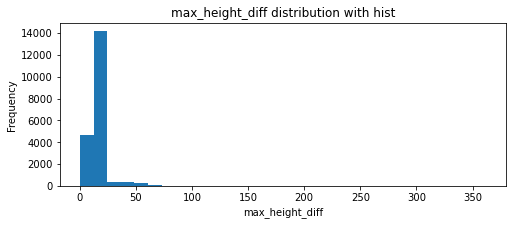

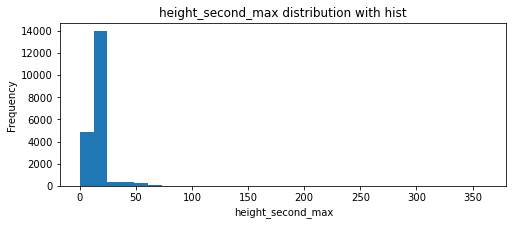

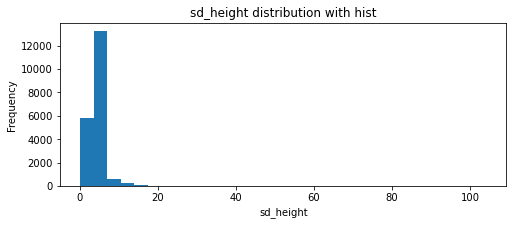

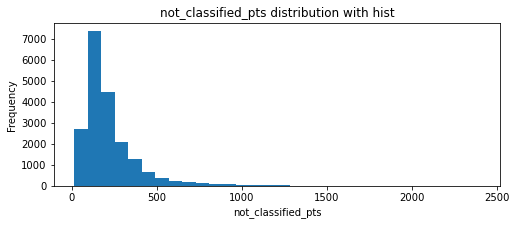

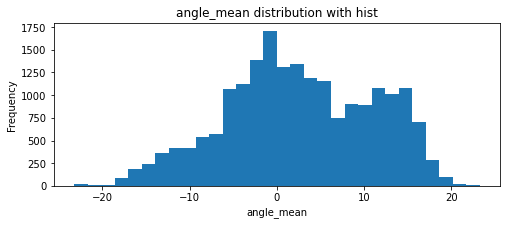

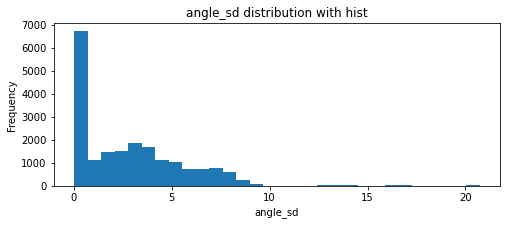

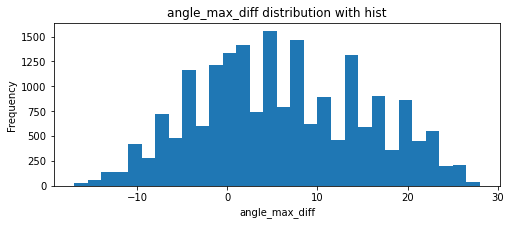

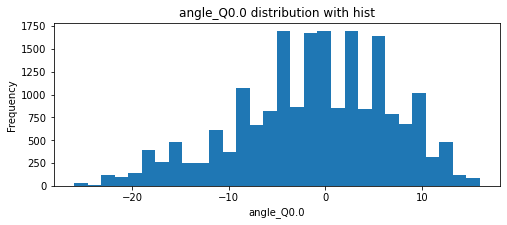

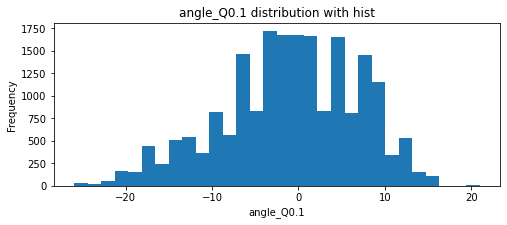

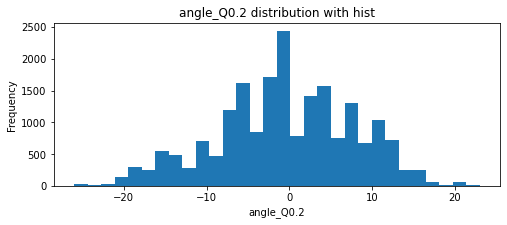

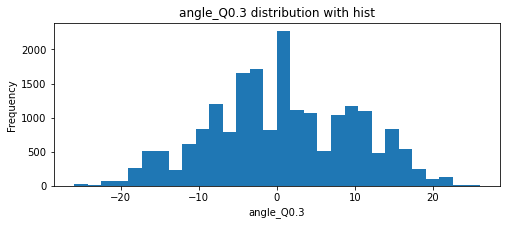

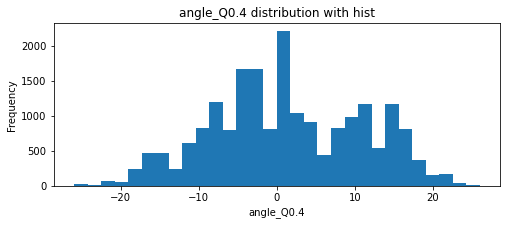

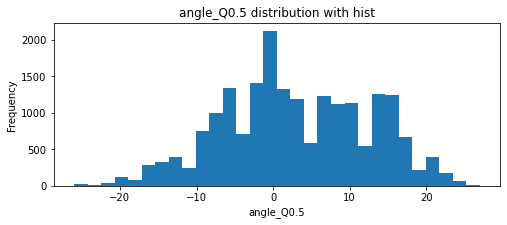

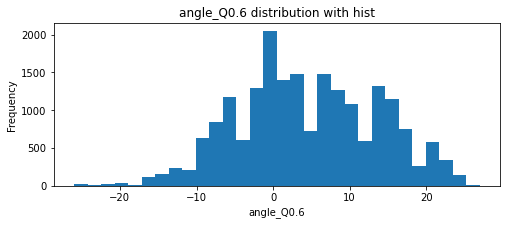

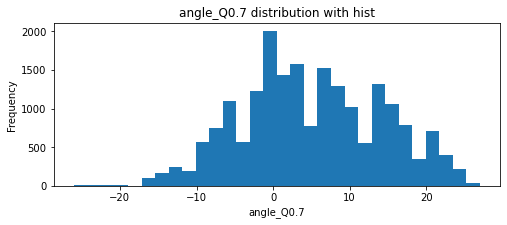

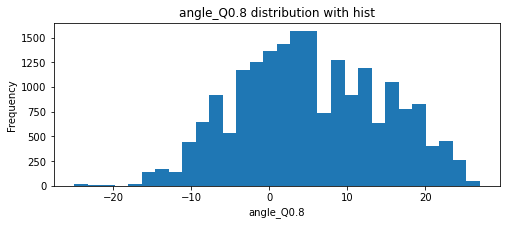

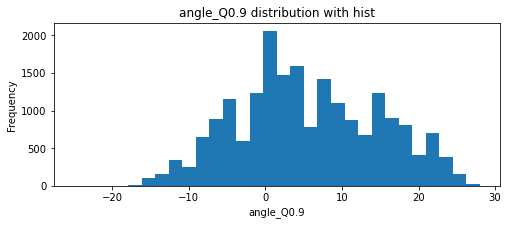

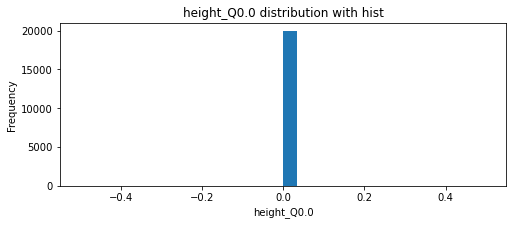

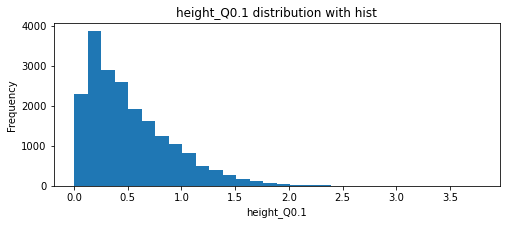

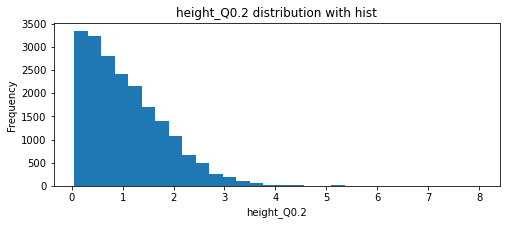

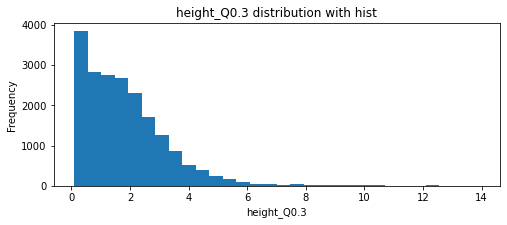

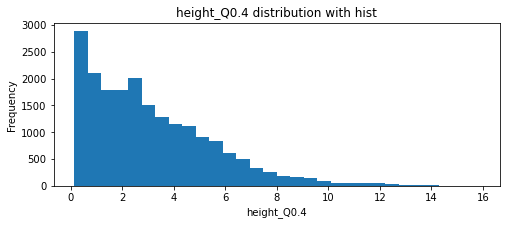

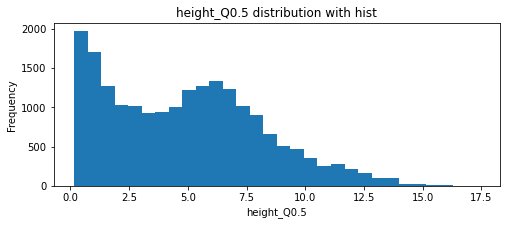

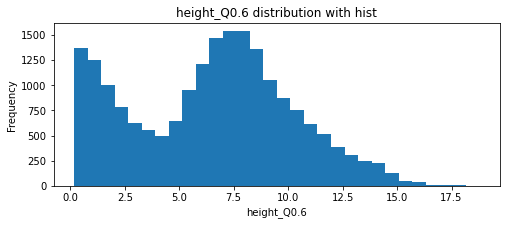

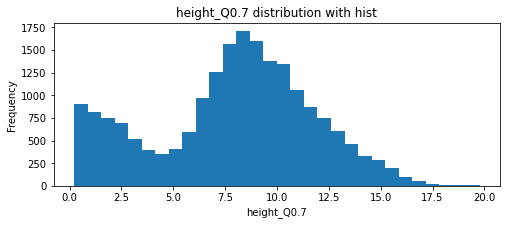

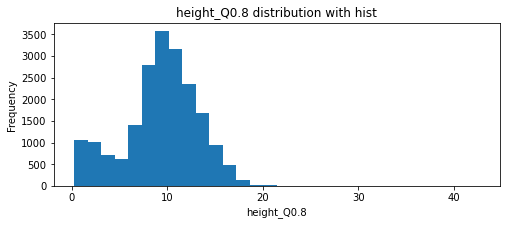

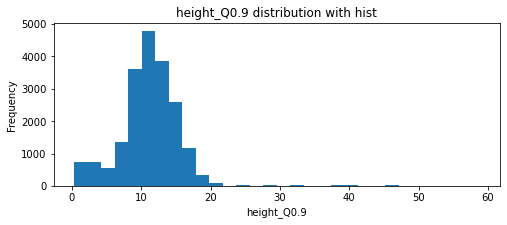

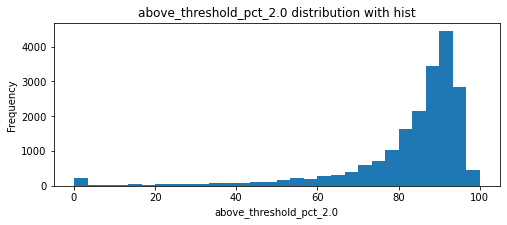

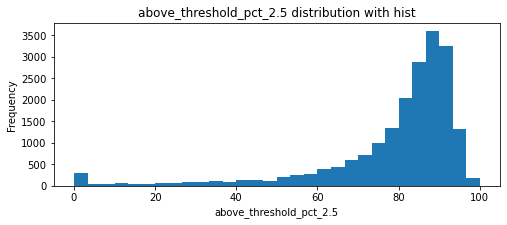

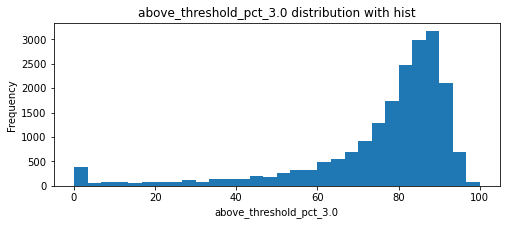

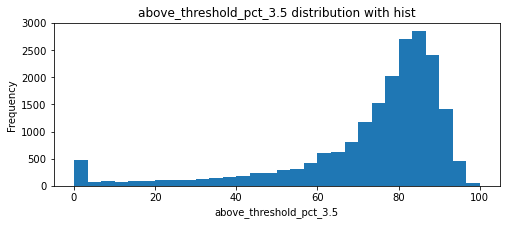

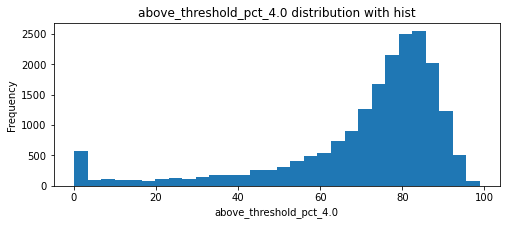

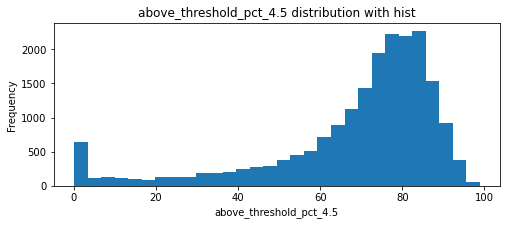

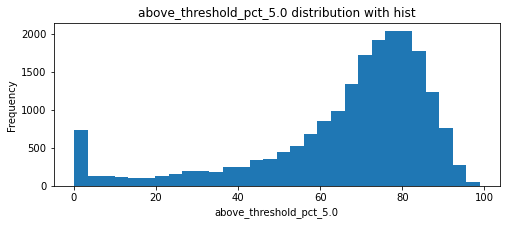

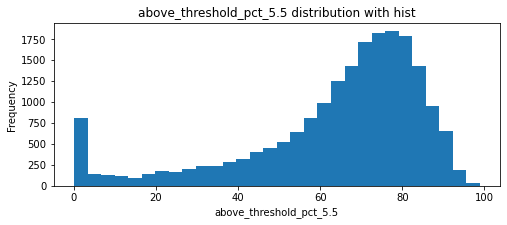

In [17]:
def plot_hist(variable):
    plt.figure(figsize = (8,3))
    plt.hist(data[variable], bins = 30)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

for n in data.columns:
    if pd.api.types.is_numeric_dtype(data[n]):
        plot_hist(n)

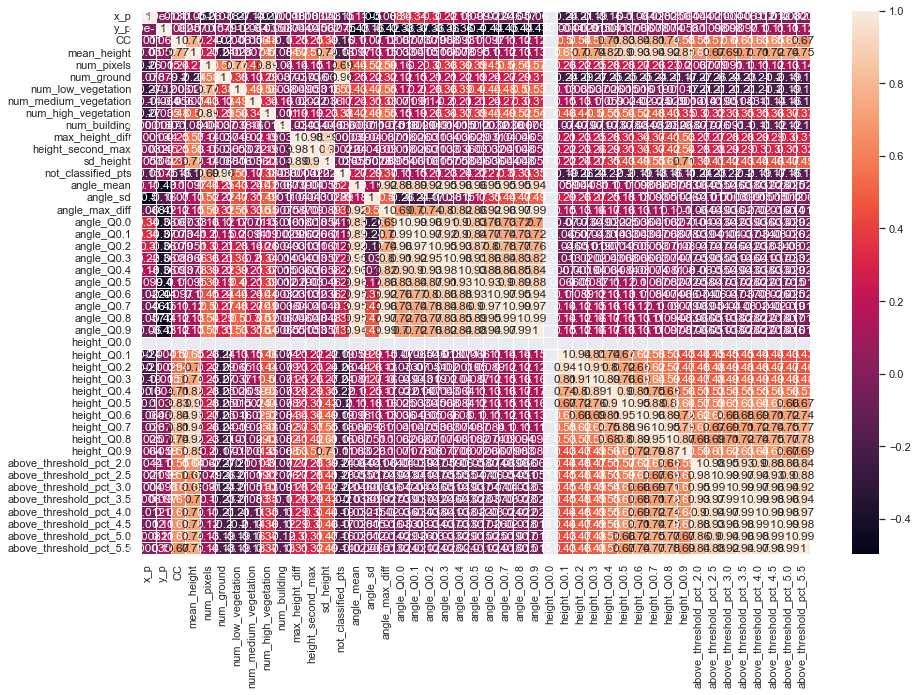

In [18]:
correlations = data.corr()
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(correlations, annot=True, linewidth=.5)
plt.show()

In [19]:
t1_EDA = time.time()

### Data splitting

In [20]:
# Attributes-Target division
X = data.loc[:, data.columns != "CC"]
y = data['CC']

In [21]:
# Data normalization
scaler = StandardScaler()
scaler.fit(X)
std_X = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [22]:
# Train-test division 
X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=0.2, random_state=123)

### Multiple linear regression model

In [23]:
t0_lin = time.time()
reg = LinearRegression().fit(std_X, y)
preds = reg.predict(std_X)

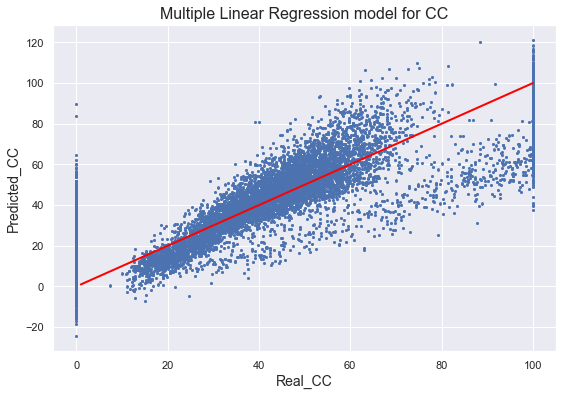

In [24]:
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y, y=preds, s=3)
plt.plot([1,100], [1,100], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("Multiple Linear Regression model for CC", fontsize=16)
plt.show()

In [25]:
r2_score(y, preds)

0.7517754709376465

In [26]:
t1_lin = time.time()

### Random forest regressor model

In [27]:
t0_rf = time.time()
regressor = RandomForestRegressor(n_estimators=10, random_state=123)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=123)

In [28]:
y_pred_rf = regressor.predict(X_test)
y_pred_train_rf = regressor.predict(X_train)

# Prediction adjustments

# If percentage is lower than 5, we set it to 0
y_pred_train_rf = [x if x>5 else 0 for x in y_pred_train_rf]
y_pred_rf = [x if x>5 else 0 for x in y_pred_rf]

# Percentage cannot be higher than 100
y_pred_train_rf = [x if x<100 else 100 for x in y_pred_train_rf]
y_pred_rf = [x if x<100 else 100 for x in y_pred_rf]


R2_train = r2_score(y_train, y_pred_train_rf)
R2_test = r2_score(y_test, y_pred_rf)

mae_train = mean_absolute_error(y_train, y_pred_train_rf)
mae_test = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest Metrics:")
print("=="*50)
print('R2 score (on train):', R2_train)
print('R2 score (on test):', R2_test)
print("=="*50)
print('MAE score (on train):', mae_train)
print('MAE score (on test):', mae_test)
print("=="*50)

R2 score (on train): 0.9855515390640279
R2 score (on test): 0.9332716511511885
MAE score (on train): 1.6729466875000008
MAE score (on test): 4.2057287500000005


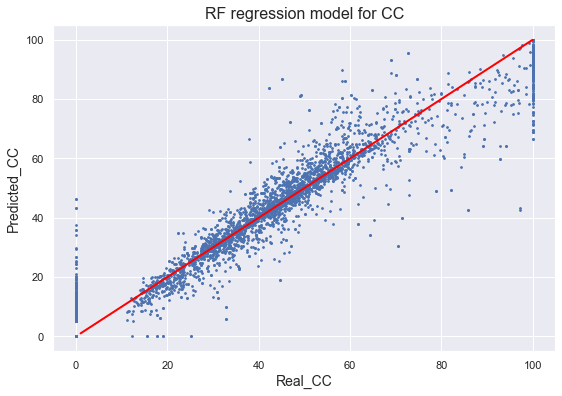

In [29]:
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y_test, y=y_pred_rf, s=3)
plt.plot([1,100], [1,100], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("RF regression model for CC", fontsize=16)
plt.show()

In [30]:
## Sending data to files
# X_test = pd.DataFrame( scaler.inverse_transform(X_test), columns=X_test.columns)
# X_test = X_test.drop(set(X_test.columns)-set(['x_p','y_p']), axis=1)


# X_train = pd.DataFrame( scaler.inverse_transform(X_train), columns=X_train.columns)
# X_train = X_train.drop(set(X_train.columns)-set(['x_p','y_p']), axis=1)

# X_test['Real_CC'] = y_test.to_numpy()
# X_test['Predicted_CC'] = y_pred

# X_train['Real_CC'] = y_train.to_numpy()
# X_train['Predicted_CC'] = y_pred_train

# X_test[['x_p','y_p','Real_CC']].to_csv(path_or_buf='./Test-RealCC.csv', sep=' ', header=False, index=False)

# X_test[['x_p','y_p','Predicted_CC']].to_csv(path_or_buf='./Test-PredictedCC.csv', sep=' ', header=False, index=False)

# X_train[['x_p','y_p','Real_CC']].to_csv(path_or_buf='./Train-RealCC.csv', sep=' ', header=False, index=False)

# X_train[['x_p','y_p','Predicted_CC']].to_csv(path_or_buf='./Train-PredictedCC.csv', sep=' ', header=False, index=False)

In [31]:
t1_rf = time.time()

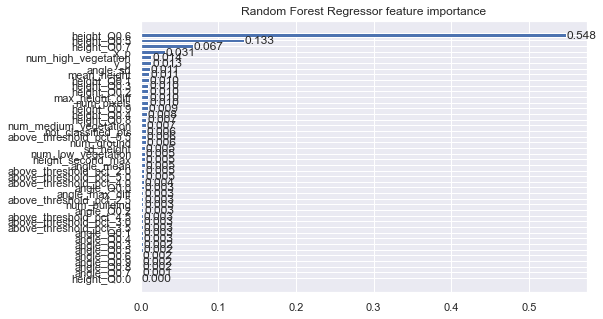

In [32]:
plt.rcParams["figure.figsize"] = (8,5)
sorted_index = regressor.feature_importances_.argsort()
parameters = list(X_train.columns)
plt.barh([parameters[i] for i in sorted_index], regressor.feature_importances_[sorted_index], height=.7)
plt.title('Random Forest Regressor feature importance')
for x, y_ in zip(regressor.feature_importances_[sorted_index], np.arange(len(parameters))):
    plt.text(x + .001, y_, f'{x:.3f}', va='center')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### XGBoost regressor model

In [33]:
t0_xgb = time.time()
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'nthread': 4,
    'max_depth': 3,
    'min_child_weight': 5,
    'colsample_bytree': 0.5,
    'objective': 'reg:linear'
}

evallist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = 50
xgb_model = xgb.train(param, dtrain, num_round, evallist, verbose_eval = 25)

y_pred = xgb_model.predict(xgb.DMatrix(X_test))
y_pred_train = xgb_model.predict(xgb.DMatrix(X_train))

[16:37:33] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-rmse:35.77428	train-rmse:35.92490
[25]	eval-rmse:12.97172	train-rmse:12.73488
[49]	eval-rmse:12.50240	train-rmse:12.06933


In [34]:
# Prediction adjustments

# If percentage is lower than 5, we set it to 0
y_pred_train = [x if x>5 else 0 for x in y_pred_train]
y_pred = [x if x>5 else 0 for x in y_pred]

# Percentage cannot be higher than 100
y_pred_train = [x if x<100 else 100 for x in y_pred_train]
y_pred = [x if x<100 else 100 for x in y_pred]

In [35]:
R2_train = r2_score(y_train, y_pred_train)
R2_test = r2_score(y_test, y_pred)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred)

print("XGBoost Metrics:")
print("=="*50)
print('R2 score (on train):', R2_train)
print('R2 score (on test):', R2_test)
print("=="*50)
print('MAE score (on train):', mae_train)
print('MAE score (on test):', mae_test)
print("=="*50)


R2 score (on train): 0.8228330239553807
R2 score (on test): 0.8091996162367384
MAE score (on train): 8.109154462903739
MAE score (on test): 8.402093571791648


In [36]:
t1_xgb = time.time()

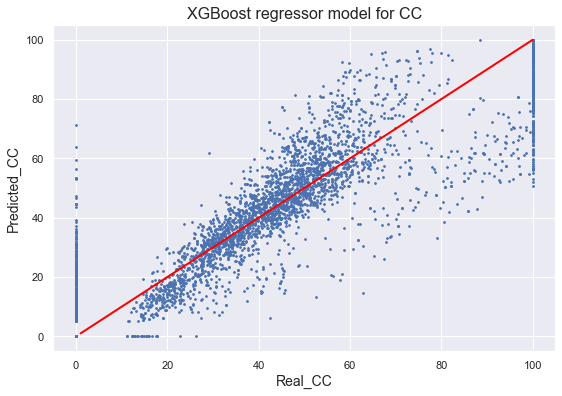

In [37]:
# Plot for the test split
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y_test, y=y_pred, s = 3)
plt.plot([1,100], [1,100], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("XGBoost regressor model for CC", fontsize=16)
plt.show()

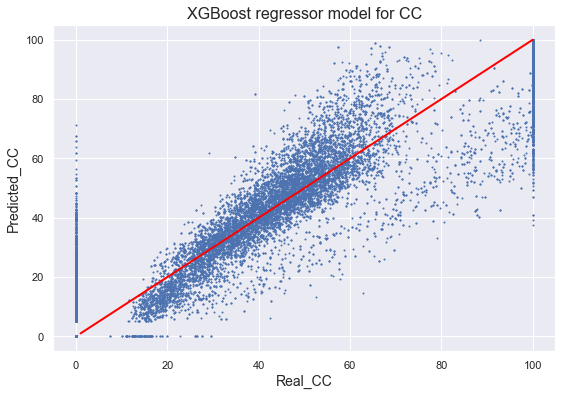

In [38]:
# Plot for the train split
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y_train, y=y_pred_train, s=1)
plt.plot([1,100], [1,100], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("XGBoost regressor model for CC", fontsize=16)
plt.show()

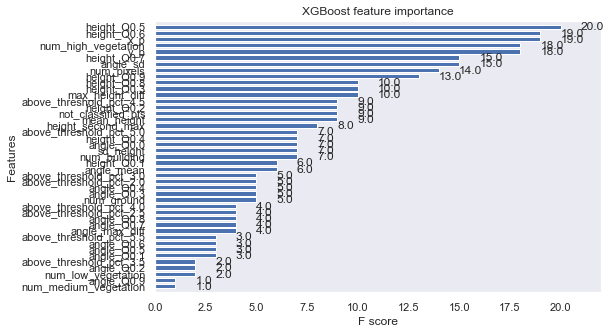

In [39]:
plt.rcParams["figure.figsize"] = (8,5)
plot_importance(xgb_model, height=0.7, grid=False, title="XGBoost feature importance")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [40]:
t1 = time.time()

print("Data loading time:", round(t1_load-t0_load,2))
print("Data pre-processing time:", round(t1_adjust-t0_adjust,2))
print("Feature extraction time:", round(t1_FE - t0_FE,2) )
print("Lineal model time:", round(t1_lin-t0_lin,2))
print("Random Forest model time:", round(t1_rf-t0_rf,2))
print("XGBoost model time:", round(t1_xgb-t0_xgb,2))
print("Total execution time: ", round(t1-t0,2))

Data loading time: 3.14
Data pre-processing time: 1.92
Feature extraction time: 82.15
Lineal model time: 0.27
Random Forest model time: 5.78
XGBoost model time: 0.41
Total execution time:  106.99
